In [88]:
import shutil
import os
import seaborn as sns

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Point, box

import whisper
import torch
import torch.nn as nn
import torch.nn.functional as F

import wandb
from tqdm import tqdm

from utils import get_device, set_all_seeds
from data import BirdClefDataset
from torch.utils.data import DataLoader

In [27]:
torch.manual_seed(42)

In [28]:
# # copy training data to subsample/ directory
# shutil.copy("../data/birdclef-2024/train_metadata.csv", "./subsample/original_train_metadata.csv")
# shutil.copy("../data/birdclef-2024/eBird_taxonomy_v2021.csv", "./subsample/eBird_taxonomy_v2021.csv")

In [33]:
training_data = gpd.read_file("./subsample/original_train_metadata.csv")

df = training_data.copy()
# drop rows with empty latitude or longitude
df = df[df['latitude'] != '']
df = df[df['longitude'] != '']

# cast to float
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)

In [34]:
# Keep in the order provided by eBird!!!!
df_classes = pd.read_csv("./subsample/eBird_taxonomy_v2021.csv")
cls2idx = {cls: i for i, cls in enumerate(df_classes['SPECIES_CODE'])}

In [35]:
df['geometry'] = df.apply(lambda x: Point(x["longitude"], x["latitude"]), axis=1)
df = gpd.GeoDataFrame(df, geometry="geometry")
df.set_crs(epsg=4326, inplace=True)

df.head()


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,geometry
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg,POINT (118.1987 39.2297)
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg,POINT (104.6401 51.403)
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg,POINT (127.3555 36.3319)
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg,POINT (70.6005 21.1697)
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg,POINT (73.7733 15.5442)


In [36]:
gb_bbox = box(-19.34,49.06,6.074,62.08)


In [37]:
gb_training_data = df[df.geometry.within(gb_bbox)]

In [38]:
# Take top 10 most frequently-represented species
cls_train = gb_training_data.groupby('primary_label').size().sort_values(ascending=False)[0:10]

cls_train = cls_train.index.to_list()

In [52]:
classes_large = df.groupby('primary_label').size().sort_values(ascending=False) > 300
# classes set to true into a list
classes_large = classes_large[classes_large].index.to_list()

In [53]:
classes_large

['eaywag1',
 'bkwsti',
 'lirplo',
 'comkin1',
 'graher1',
 'comros',
 'comsan',
 'eurcoo',
 'houspa',
 'grnsan',
 'commoo3',
 'grewar3',
 'comgre',
 'litgre1',
 'woosan',
 'grywag',
 'eucdov',
 'bcnher',
 'zitcis1',
 'hoopoe',
 'blrwar1',
 'barswa',
 'rorpar',
 'litegr']

In [55]:
# Sample 100 examples for each class 
df_large = pd.DataFrame()
for cls in classes_large:
    df_cls = gb_training_data[gb_training_data['primary_label'] == cls][0:100]
    df_large = pd.concat([df_large, df_cls])

In [57]:
df_large.to_csv("./subsample/large/train_metadata_large.csv", index=False)

In [63]:
# copy sounds from data into notebooks/subsample/large, based on df_large
for idx, row in df_large.iterrows():
    # make directory if it doesn't exist
    os.makedirs(f"./subsample/large/{row['primary_label']}", exist_ok=True)
    shutil.copy(f"../data/birdclef-2024/train_audio/{row['filename']}", f"./subsample/large/{row['filename']}")
# visualize with basemap

In [72]:
# join df and df_classes on SPECIES_CODE = primary_label
df_large_classes = df.merge(df_classes, left_on='primary_label', right_on='SPECIES_CODE', how='left')
# visualize with basemap

In [80]:
df_large_classes['ORDER1'].unique()

array(['Passeriformes', 'Cuculiformes', 'Ciconiiformes',
       'Caprimulgiformes', 'Pelecaniformes', 'Piciformes',
       'Accipitriformes', 'Charadriiformes', 'Strigiformes',
       'Coraciiformes', 'Gruiformes', 'Galliformes', 'Suliformes',
       'Columbiformes', 'Anseriformes', 'Bucerotiformes',
       'Podicipediformes', 'Psittaciformes', 'Trogoniformes'],
      dtype=object)

In [84]:
df_large_classes['ORDER1'].dropna().unique().tolist()

['Passeriformes',
 'Cuculiformes',
 'Ciconiiformes',
 'Caprimulgiformes',
 'Pelecaniformes',
 'Piciformes',
 'Accipitriformes',
 'Charadriiformes',
 'Strigiformes',
 'Coraciiformes',
 'Gruiformes',
 'Galliformes',
 'Suliformes',
 'Columbiformes',
 'Anseriformes',
 'Bucerotiformes',
 'Podicipediformes',
 'Psittaciformes',
 'Trogoniformes']

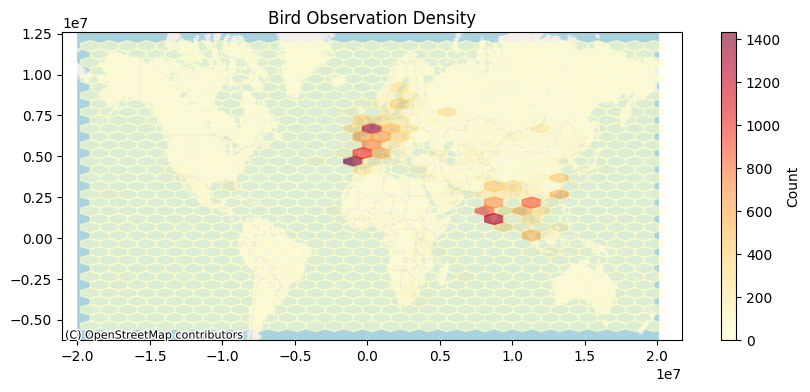

In [97]:
# Create heatmap using hexbin
fig, ax = plt.subplots(figsize=(10, 4))

# Convert to web mercator projection for proper display
gdf_projected = df_large_classes.to_crs(epsg=3857)

# Create hexbin plot
hb = ax.hexbin(
    gdf_projected.geometry.x, 
    gdf_projected.geometry.y,
    gridsize=30,  # Adjust this value to change the resolution
    cmap='YlOrRd',  # Heat-map like colormap
    alpha=0.6
)

# Add colorbar
plt.colorbar(hb, label='Count')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Bird Observation Density')
plt.show()


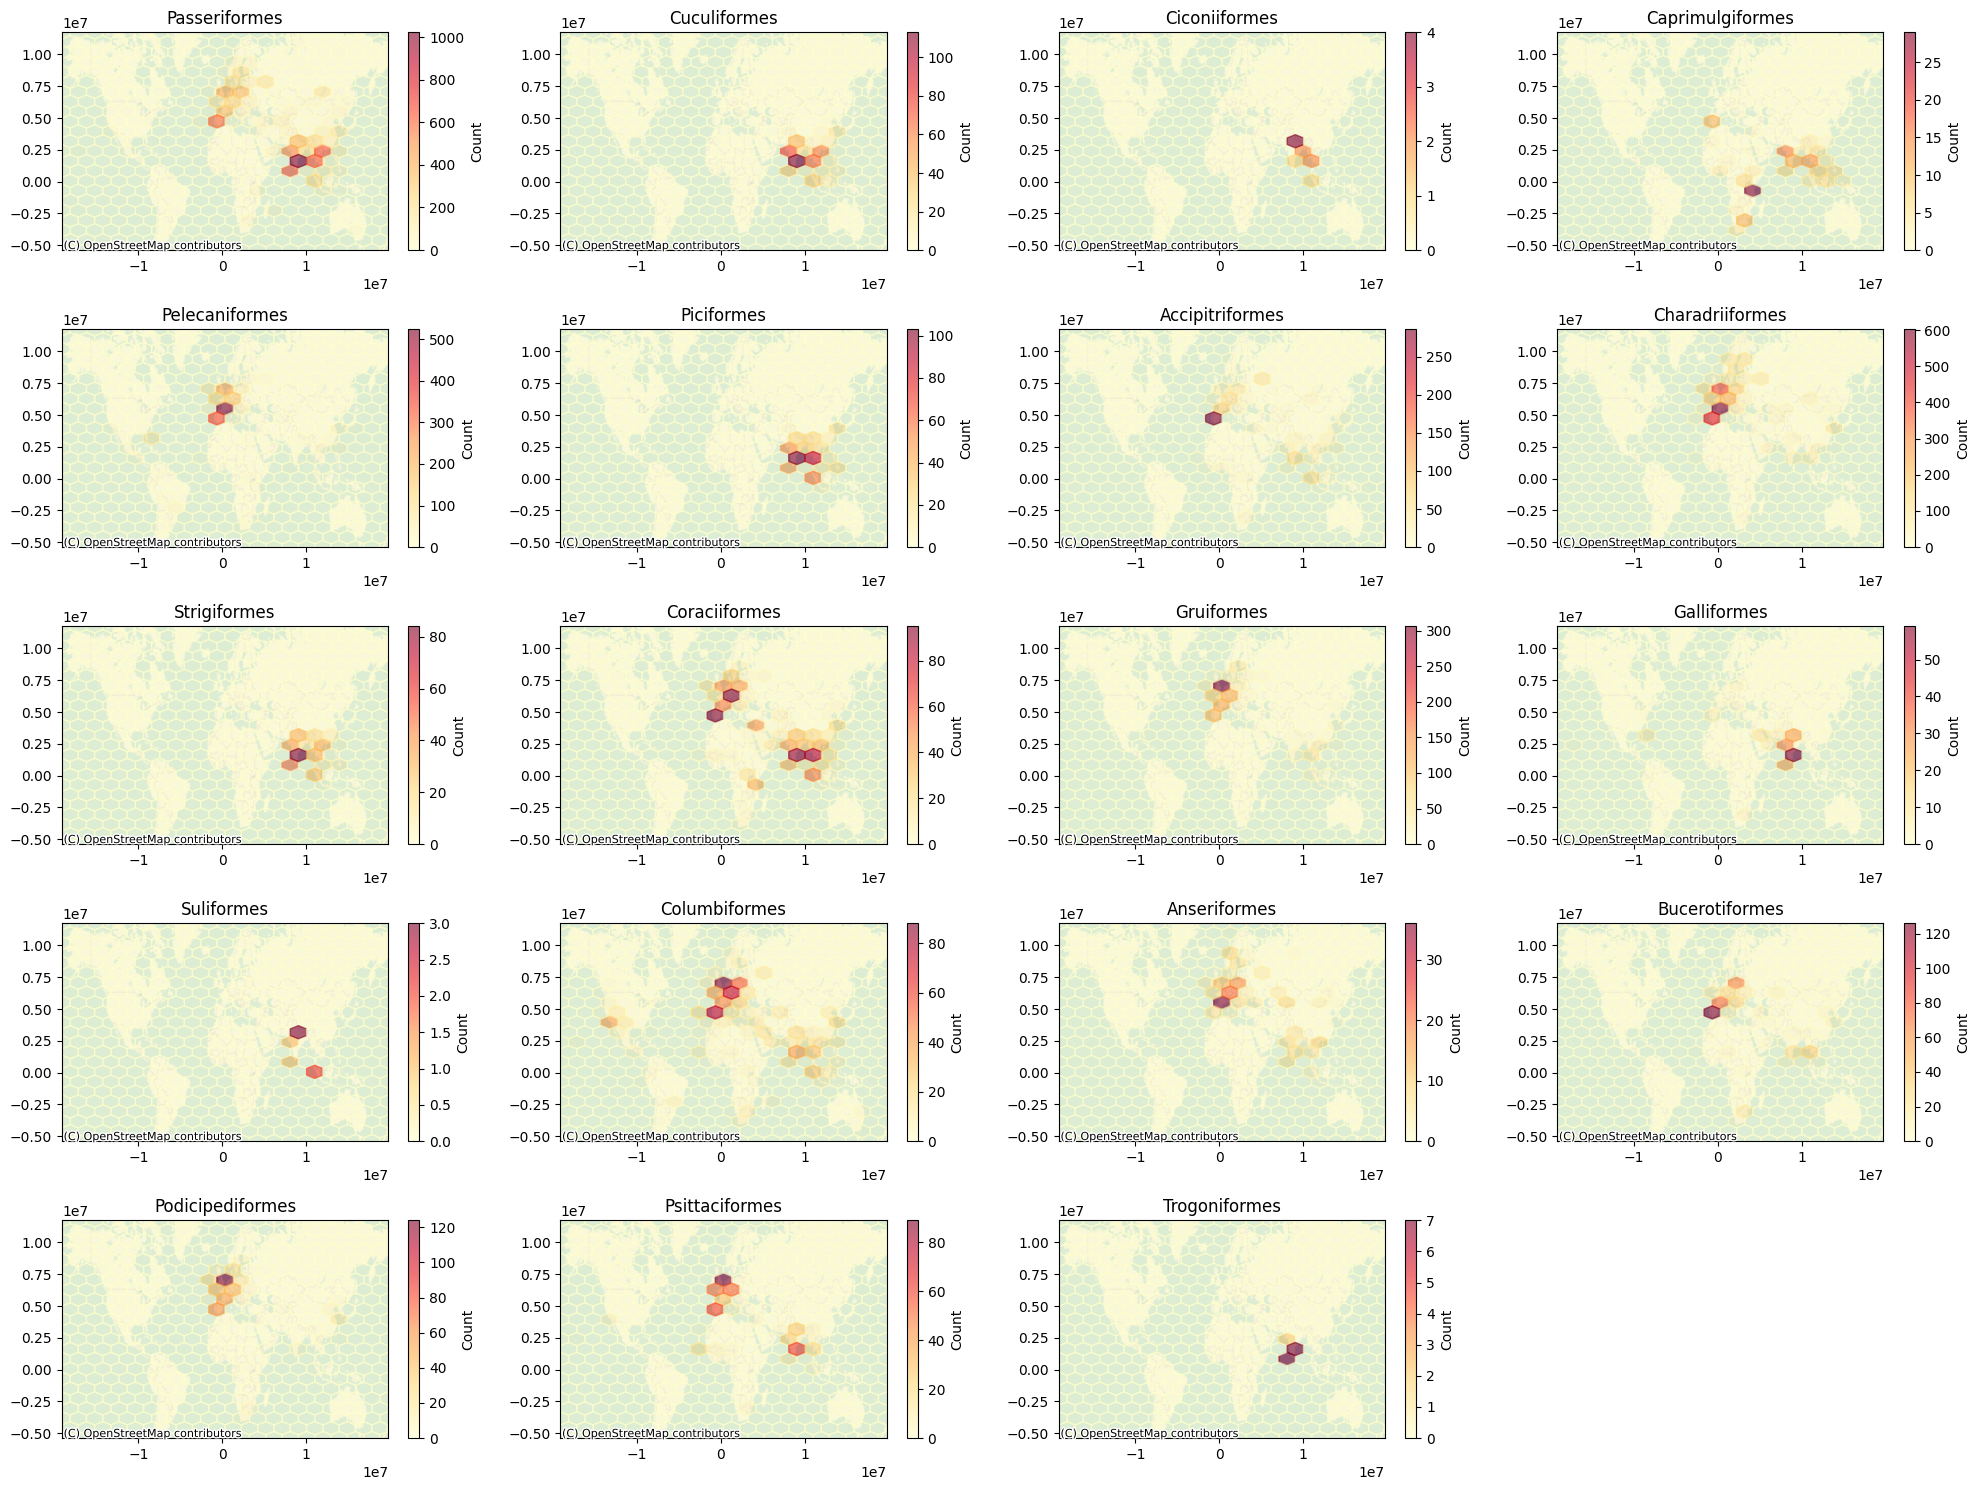

In [100]:
# Get unique orders, dropping any NaN values
orders = df_large_classes['ORDER1'].dropna().unique()

# Calculate number of rows and columns needed for the grid
n_orders = len(orders)
n_cols = 4  # You can adjust this
n_rows = (n_orders + n_cols - 1) // n_cols  # Ceiling division

# Create figure and axes grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))  # Reduced height per row
axes = axes.flatten()  # Flatten to make indexing easier

# Convert to web mercator projection once for efficiency
gdf_projected = df_large_classes.to_crs(epsg=3857)

# Get the world extent from all data points
x_min, y_min, x_max, y_max = gdf_projected.total_bounds

# Create a plot for each order
for idx, order in enumerate(orders):
    ax = axes[idx]
    
    # Filter data for this order
    order_data = gdf_projected[gdf_projected['ORDER1'] == order]
    
    # Create hexbin plot
    hb = ax.hexbin(
        order_data.geometry.x,
        order_data.geometry.y,
        gridsize=20,
        cmap='YlOrRd',
        alpha=0.6,
        extent=[x_min, x_max, y_min, y_max]  # Set consistent extent
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    
    # Set consistent limits for all plots
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Add title and colorbar
    ax.set_title(order)
    plt.colorbar(hb, ax=ax, label='Count')

# Remove any empty subplots
for idx in range(len(orders), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


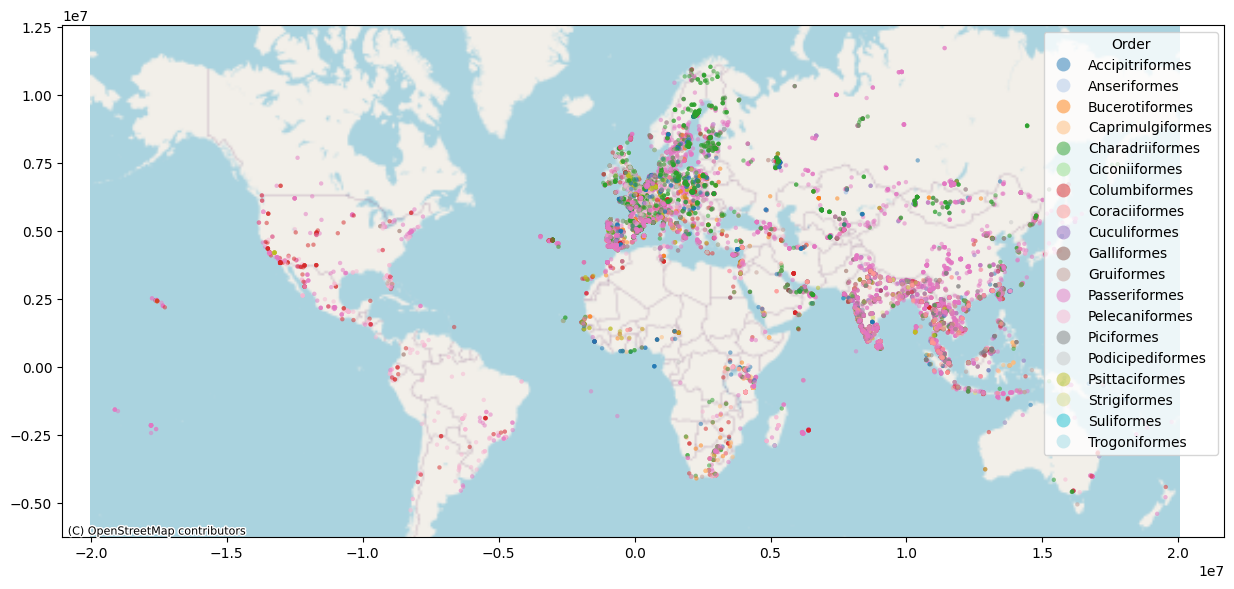

In [85]:
# Create plot with legend
ax = df_large_classes.to_crs(epsg=3857).plot(
    figsize=(15,10), 
    alpha=0.5, 
    edgecolor='none', 
    column='ORDER1', 
    cmap='tab20', 
    markersize=10,
    legend=True,  # This is key - let geopandas handle the legend
    legend_kwds={'title': 'Order', 'loc': 'upper right'}
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

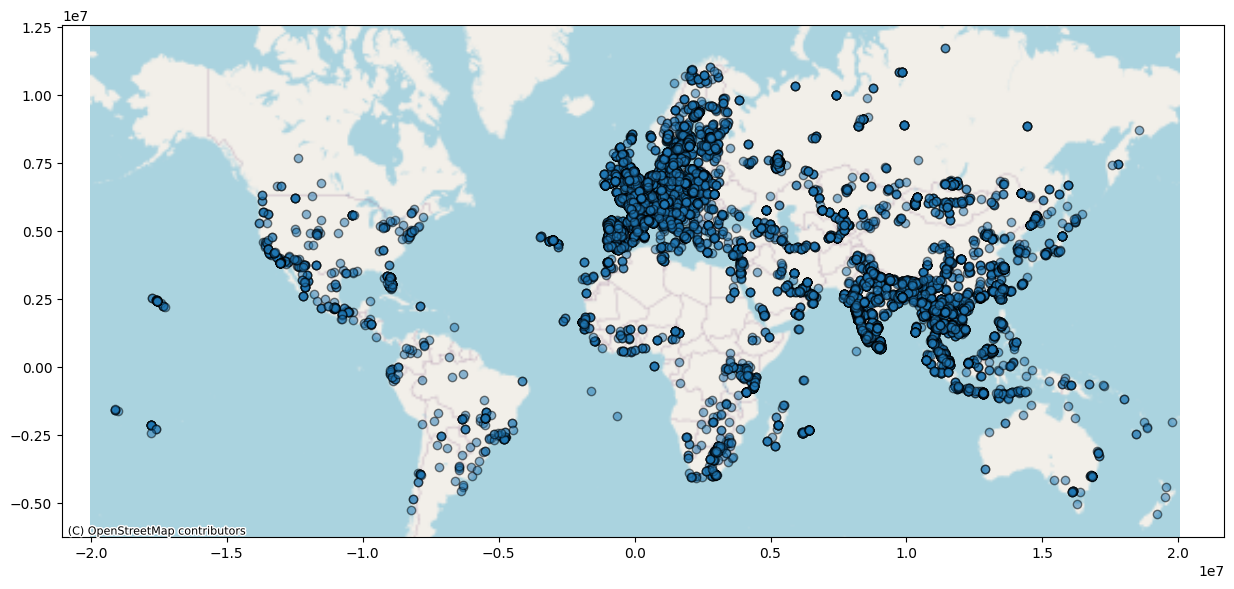

In [67]:
# visualize with basemap
ax = df.to_crs(epsg=3857).plot(figsize=(15,10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()



## Example 2 : A small sample of audio files

10 species, 10 examples each
- take 10 species
- for each species, take 10 clips
- classify with our classifier
- train a new classifier on the new data
- test on unseen clips from the same species

## Data Prep

In [10]:
# Take top 10 most frequently-represented species
cls_train = gb_training_data.groupby('primary_label').size().sort_values(ascending=False)[0:10]

cls_train = cls_train.index.to_list()
cls2idx_sample = {cls: i for i, cls in enumerate(cls_train)}

In [11]:
df_sample_classes = df_classes[df_classes['SPECIES_CODE'].isin(cls_train)].reset_index(drop=True)

In [12]:
## If we need to regenerate the sample data, we can do so here:
# np.random.seed(42) # note that the data below was not generated with this seed
# df_train = pd.DataFrame()
# df_test = pd.DataFrame()
# for cls in cls_train:
#     df_cls = gb_training_data[gb_training_data['primary_label'] == cls].sample(n=15)
#     df_train = pd.concat([df_train, df_cls[0:10]])
#     df_test = pd.concat([df_test, df_cls[10:15]])
# df_train.to_csv("./subsample/train_metadata.csv", index=False)
# df_test.to_csv("./subsample/test_metadata.csv", index=False)


df_train = pd.read_csv("./subsample/train_metadata.csv")
df_test = pd.read_csv("./subsample/test_metadata.csv")
print("df_sample_classes are the same as in df_train:", 
    sorted(list(df_train['primary_label'].unique())) == sorted(cls_train))
df_train.head()

df_sample_classes are the same as in df_train: True


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,geometry
0,eurcoo,[],['call'],51.3672,5.8406,Fulica atra,Eurasian Coot,Ad Hilders,Creative Commons Attribution-NonCommercial-Sha...,3.0,http://xeno-canto.org/671670,eurcoo/XC671670.ogg,POINT (5.8406 51.3672)
1,eurcoo,[],"['begging call', 'juvenile']",51.4269,5.4752,Fulica atra,Eurasian Coot,Jorge Leitão,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/573675,eurcoo/XC573675.ogg,POINT (5.4752 51.4269)
2,eurcoo,[],[''],54.1323,-0.1239,Fulica atra,Eurasian Coot,Mark Pearson,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/808756,eurcoo/XC808756.ogg,POINT (-0.1239 54.1323)
3,eurcoo,[],[''],52.6975,-0.5962,Fulica atra,Eurasian Coot,Andrew Harrop,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/819364,eurcoo/XC819364.ogg,POINT (-0.5962 52.6975)
4,eurcoo,[],['flight call'],51.9400,5.9038,Fulica atra,Eurasian Coot,Joost van Bruggen,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/384481,eurcoo/XC384481.ogg,POINT (5.9038 51.94)


## Classification
We have now hijacked the Whisper encoder to produce an encoded representation of the audio clip. 

There are a few ways to do this — I'm curious to see how they compare.

In [13]:
from core import WhisperClassifierMeanPool, WhisperClassifierMeanPoolFF, WhisperClassifierMaxPoolFF

In [14]:
# hard reload birdclefdataset, local module

# import importlib
# import data
# importlib.reload(data)
# from data import BirdClefDataset

In [15]:
# Hyperparameters
EPOCHS_10 = 10
BATCH_SIZE_2 = 2
LEARNING_RATE_001 = 0.001
WHISPER_MODEL_SMALL = "small"
NUM_CLASSES_10 = len(df_sample_classes)
RANDOM_SEED = 42

DEVICE = get_device()

In [16]:
dataset_train = BirdClefDataset(df_train, "./subsample", df_sample_classes, 'train')
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE_2, shuffle=False)
    # TODO: Optimize batch_size for GPU

In [17]:
classifier_mean_pool = WhisperClassifierMeanPool(WHISPER_MODEL_SMALL, NUM_CLASSES_10)
classifier_mean_pool.to(classifier_mean_pool.device)
c_mean_pool_optimizer = torch.optim.Adam(classifier_mean_pool.parameters(), lr=LEARNING_RATE_001)
c_mean_pool_criterion = torch.nn.CrossEntropyLoss()

# classifier_mean_pool_ff = WhisperClassifierMeanPoolFF(WHISPER_MODEL_SMALL, NUM_CLASSES_10)
# classifier_mean_pool_ff.to(classifier_mean_pool_ff.device)
# c_mean_pool_ff_optimizer = torch.optim.Adam(classifier_mean_pool_ff.parameters(), lr=LEARNING_RATE_001)
# c_mean_pool_ff_criterion = torch.nn.CrossEntropyLoss()

# classifier_max_pool_ff = WhisperClassifierMaxPoolFF(WHISPER_MODEL_SMALL, NUM_CLASSES_10)
# classifier_max_pool_ff.to(classifier_max_pool_ff.device)
# c_max_pool_ff_optimizer = torch.optim.Adam(classifier_max_pool_ff.parameters(), lr=LEARNING_RATE_001)
# c_max_pool_ff_criterion = torch.nn.CrossEntropyLoss()


/Users/x25bd/Code/mlx/week-7/mlx-whisper/.venv/lib/python3.9/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp,

In [18]:
models = {
    "mean_pool": {
        "model": classifier_mean_pool,
        "optimizer": c_mean_pool_optimizer,
        "criterion": c_mean_pool_criterion,
    },
    # "mean_pool_ff": {
    #     "model": classifier_mean_pool_ff,
    #     "optimizer": c_mean_pool_ff_optimizer,
    #     "criterion": c_mean_pool_ff_criterion,
    # },
    # "max_pool_ff": {
    #     "model": classifier_max_pool_ff,
    #     "optimizer": c_max_pool_ff_optimizer,
    #     "criterion": c_max_pool_ff_criterion,
    # }
}


In [20]:
def train_model(model, 
                optimizer, 
                criterion, 
                dataloader, 
                epochs, 
                model_name, 
                seed=42):
    
    set_all_seeds(seed)

    device = get_device()
    model = model.to(device)
    model.train()

    for epoch in tqdm(range(epochs), desc=f"Training {model_name}"):
        epoch_loss = 0.0

        for batch_idx, batch in tqdm(
            enumerate(dataloader), 
            desc="Training", 
            total=len(dataloader)):
        
            optimizer.zero_grad()
            mel_spectrograms, target_classes, _ = batch
            mel_spectrograms = mel_spectrograms.to(model.device)
            target_classes = target_classes.to(model.device)

            logits = model(mel_spectrograms)
            loss = criterion(logits, target_classes)

            loss.backward()
            optimizer.step()

            wandb.log({
                f"{model_name}/batch_loss": loss.item()
            })
        
        wandb.log({
            f"{model_name}/epoch_loss": epoch_loss / len(dataloader)
        })
        # Save model
        # torch.save(model.state_dict(), f"./subsample/models/{model_name}.pth")
            


In [21]:
wandb.init(project="mlx-whisper", name="train-classifier-experiments")

for model_name, model_info in models.items():
    train_model(model=model_info["model"], 
                optimizer=model_info["optimizer"], 
                criterion=model_info["criterion"], 
                dataloader=dataloader_train, 
                epochs=EPOCHS_10, 
                model_name=model_name, 
                seed=RANDOM_SEED)

wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: johnx (machine-learning-institute). Use `wandb login --relogin` to force relogin


Training mean_pool: 100%|██████████| 10/10 [26:58<00:00, 161.81s/it]


mean_pool/batch_loss,▁▇█▆▄▃▇▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
mean_pool/epoch_loss,▁▁▁▁▁▁▁▁▁▁
mean_pool/batch_loss,2.69687
mean_pool/epoch_loss,0


In [101]:
dataset_test = BirdClefDataset(df_test, "./subsample", df_sample_classes, "test")
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [102]:
model = models["mean_pool"]["model"]
criterion = models["mean_pool"]["criterion"]
classifier = model
model.eval()
for batch_idx, (mel_input, cls_actual, _) in tqdm(enumerate(dataloader_test), desc="Testing", total=len(dataloader_test)):
    mel_input = mel_input.to(model.device)
    cls_actual = cls_actual.to(model.device)

    logits = classifier(mel_input)
    loss = criterion(logits, cls_actual)
    predicted_idx = torch.argmax(logits, dim=1).item()
    actual_idx = torch.argmax(cls_actual, dim=1).item()
    predicted = df_sample_classes.iloc[predicted_idx]
    actual = df_sample_classes.iloc[actual_idx]
    print(f"""
====================
          Predicted: {predicted['SPECIES_CODE']} ({predicted['PRIMARY_COM_NAME']})
          Actual: {actual['SPECIES_CODE']} ({actual['PRIMARY_COM_NAME']})
          Loss: {loss.item()}
""")


Testing:   0%|          | 0/50 [00:33<?, ?it/s]


KeyboardInterrupt: 

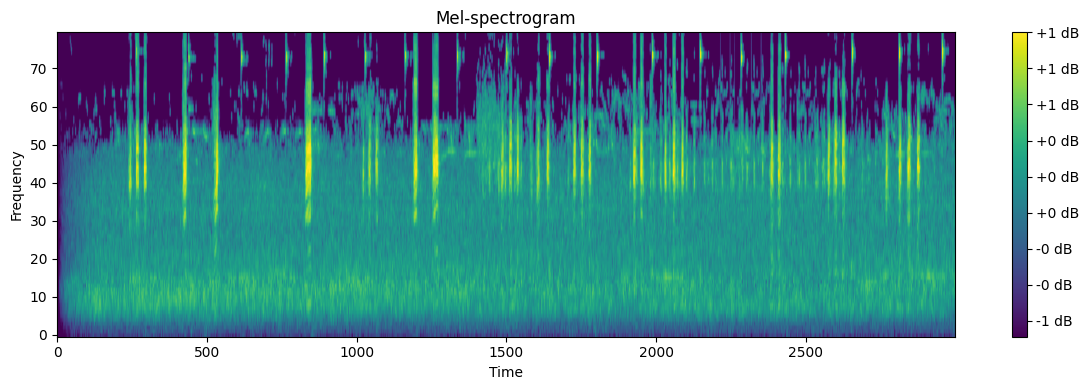

In [112]:
# visualize spectrogram of mel input, make the image taller
# Visualize spectrogram of mel_input
plt.figure(figsize=(12, 4))  # Adjust the figure size for better proportions
plt.imshow(mel_input.squeeze(0).cpu().numpy(), aspect='auto', origin='lower', cmap='viridis')  # Use 'viridis' for a visually appealing colormap
plt.colorbar(format='%+2.0f dB')  # Add a colorbar with decibel format
plt.title('Mel-spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()